In [1]:
import os
import re
import yaml

import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
config_name = "kjernekraft"
with open(f"../config/{config_name}.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

calculate_statistics = True

In [3]:
if calculate_statistics:
    net_dir = f"../results/{config_name}/postnetworks"
    networks = pd.DataFrame(
        columns=[
            "n",
            "line",
            "nuclear_cost",
            "CO2",
            "onwind_cost",
            "offwind_cost",
            "solar_cost",
            "onwind_potential",
            "solar_potential",
        ]
    )

    # Gå gjennom alle nettverka i resultatsmappa og les dei inn i ein dataframe.
    for file in os.listdir(net_dir):
        n = pypsa.Network(f"{net_dir}/{file}")

        # Kostnad kjernekraft: "nuclear+c<float>"-delen av filnamnet.
        nuclear_cost = re.search(r"nuclear\+c(\d+\.\d+)", file)
        if nuclear_cost:
            nuclear_cost = float(nuclear_cost.group(1))
        else:
            nuclear_cost = 1

        # Transmisjonsnett expansjon: "lc<float>"-delen av filnamnet.
        line_expansion = re.search(r"_lc(\d+\.\d+)_", file)
        if line_expansion:
            line_expansion = float(line_expansion.group(1))
        else:
            line_expansion = 1

        # CO2-grense: "Co2L<float>"-delen av filnamnet.
        CO2_limit = re.search(r"Co2L(\d+\.\d+)", file)
        if CO2_limit:
            CO2_limit = float(CO2_limit.group(1))
        else:
            CO2_limit = 0

        # Kostnad landbasert vindkraft: "onwind+c<float>"-delen av filnamnet.
        onwind_cost = re.search(r"onwind\+c(\d+\.\d+)", file)
        if onwind_cost:
            onwind_cost = float(onwind_cost.group(1))
        else:
            onwind_cost = 1

        # Kostnad havvind: "offwind+c<float>"-delen av filnamnet.
        offwind_cost = re.search(r"offwind\+c(\d+\.\d+)", file)
        if offwind_cost:
            offwind_cost = float(offwind_cost.group(1))
        else:
            offwind_cost = 1

        # Get the solar cost factor, of form solar+c<float>.
        solar_cost = re.search(r"solar\+c(\d+\.\d+)", file)
        if solar_cost:
            solar_cost = float(solar_cost.group(1))
        else:
            solar_cost = 1

        # Arealbegrensing for landbasert vindkraft: "onwind+p<float>"-delen av filnamnet.
        onwind_potential = re.search(r"onwind\+p(\d+\.\d+)", file)
        if onwind_potential:
            onwind_potential = float(onwind_potential.group(1))
        else:
            onwind_potential = 1

        # Arealbegrensing for solkraft: "solar+p<float>"-delen av filnamnet.
        solar_potential = re.search(r"solar\+p(\d+\.\d+)", file)
        if solar_potential:
            solar_potential = float(solar_potential.group(1))
        else:
            solar_potential = 1

        networks.loc[file] = [
            n,
            line_expansion,
            nuclear_cost,
            CO2_limit,
            onwind_cost,
            offwind_cost,
            solar_cost,
            onwind_potential,
            solar_potential,
        ]
else:
    networks = pd.read_csv("network_statistics.csv", index_col=0)

INFO:pypsa.io:Imported network elec_s_100_lc1.25__Co2L0.1-2000SEG-T-H-B-I-A-solar+p3-dist1-EQ0.9c-solar+c1.3-nuclear+c0.5_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_lc1.25__Co2L0-2000SEG-T-H-B-I-A-solar+p3-dist1-EQ0.9c-nuclear+c0.6_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_lc1.5__Co2L0.05-2000SEG-T-H-B-I-A-solar+p3-dist1-EQ0.9c-solar+c1.3-nuclear+c0.6_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_lc1.5__Co2L0.05-2000SEG-T-H-B-I-A-solar+p3-dist1-EQ0.9c-nuclear+c0.6_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_lc1.25__Co2L0.1-2000SEG-T-H-B-I-A-solar+p3-dist1-EQ0.9c-nuclear+c0.9_2050.nc h

# Førebuing

In [20]:
# Rekn ut investeringar i kvar energikjelde, samt produksjon, først for heile Europa og so for Noreg.
gen_mask_NO = networks.n[0].generators.bus.map(networks.n[0].buses.country) == "NO"
link_mask_NO = networks.n[0].links.bus1.map(networks.n[0].buses.country) == "NO"
gen_mask_EU = True
link_mask_EU = True

for gen_mask, link_mask, code in zip(
    [gen_mask_NO, gen_mask_EU], [link_mask_NO, link_mask_EU], ["NO", "EU"]
):
    for i, n in networks.n.items():
        # Kjernekraft:
        nuclear_i = n.links.loc[(n.links.carrier == "nuclear") & link_mask].index
        networks.loc[i, f"nuclear_inv_{code}"] = (
            n.links.loc[nuclear_i, "capital_cost"] * n.links.loc[nuclear_i, "p_nom_opt"]
        ).sum()
        networks.loc[i, f"nuclear_cap_{code}"] = (
            n.links.loc[nuclear_i, "p_nom_opt"] * n.links.loc[nuclear_i, "efficiency"]
        ).sum()
        networks.loc[i, f"nuclear_prod_{code}"] = (
            n.snapshot_weightings["generators"] @ n.links_t.p0.loc[:, nuclear_i]
        ).sum()

        # Landbasert vindkraft:
        onwind_i = n.generators.loc[(n.generators.carrier == "onwind") & gen_mask].index
        networks.loc[i, f"onwind_inv_{code}"] = (
            n.generators.loc[onwind_i, "capital_cost"]
            * n.generators.loc[onwind_i, "p_nom_opt"]
        ).sum()
        networks.loc[i, f"onwind_cap_{code}"] = n.generators.loc[
            onwind_i, "p_nom_opt"
        ].sum()
        networks.loc[i, f"onwind_prod_{code}"] = (
            n.snapshot_weightings["generators"] @ n.generators_t.p[onwind_i]
        ).sum()

        # Solkraft:
        solar_i = n.generators.loc[(n.generators.carrier == "solar") & gen_mask].index
        networks.loc[i, f"solar_inv_{code}"] = (
            n.generators.loc[solar_i, "capital_cost"]
            * n.generators.loc[solar_i, "p_nom_opt"]
        ).sum()
        networks.loc[i, f"solar_cap_{code}"] = n.generators.loc[
            solar_i, "p_nom_opt"
        ].sum()
        networks.loc[i, f"solar_prod_{code}"] = (
            n.snapshot_weightings["generators"] @ n.generators_t.p[solar_i]
        ).sum()

        # Havvind:
        offwind_i = n.generators.loc[
            n.generators.carrier.isin(["offwind-ac", "offwind-dc"]) & gen_mask
        ].index
        networks.loc[i, f"offwind_inv_{code}"] = (
            n.generators.loc[offwind_i, "capital_cost"]
            * n.generators.loc[offwind_i, "p_nom_opt"]
        ).sum()
        networks.loc[i, f"offwind_cap_{code}"] = n.generators.loc[
            offwind_i, "p_nom_opt"
        ].sum()
        networks.loc[i, f"offwind_prod_{code}"] = (
            n.snapshot_weightings["generators"] @ n.generators_t.p[offwind_i]
        ).sum()

In [21]:
# Eksporter dataframen til CSV for lettare gjenbruk.
networks.drop("n", axis=1).to_csv("network_statistics.csv")

# Kjernekraft som andel av investering, kapasitet, produksjon

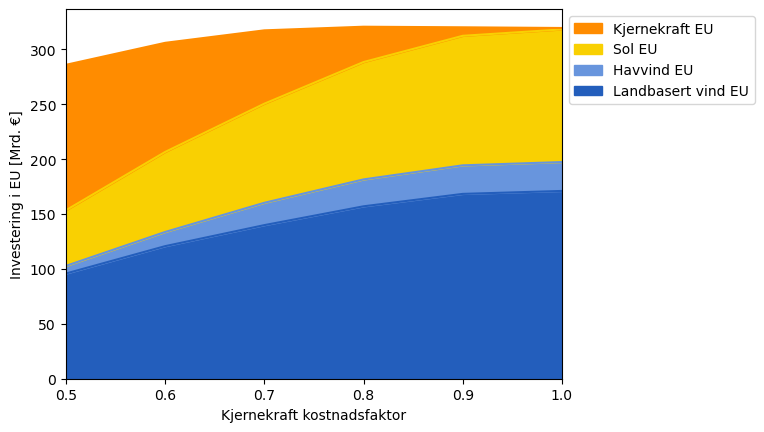

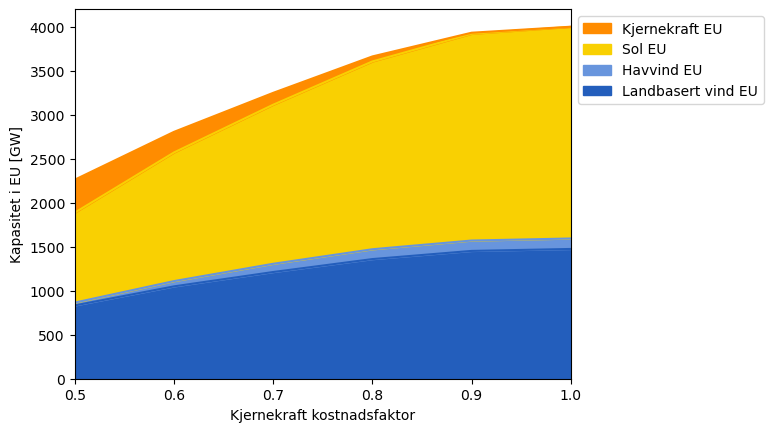

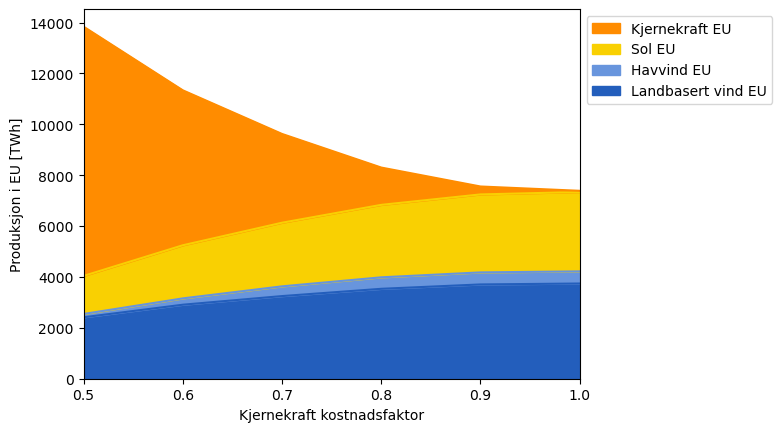

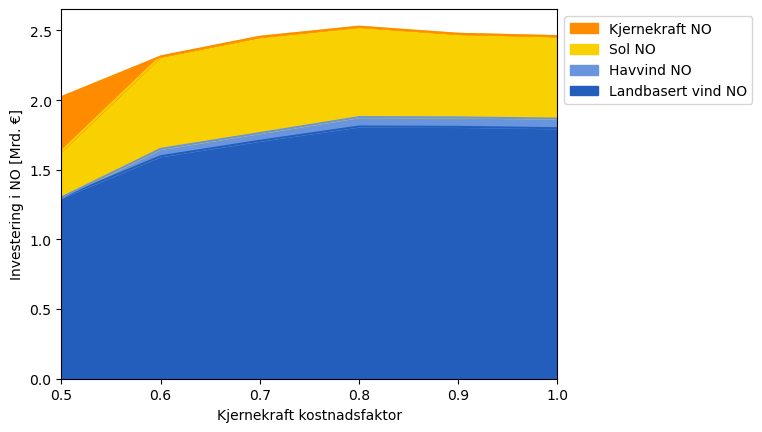

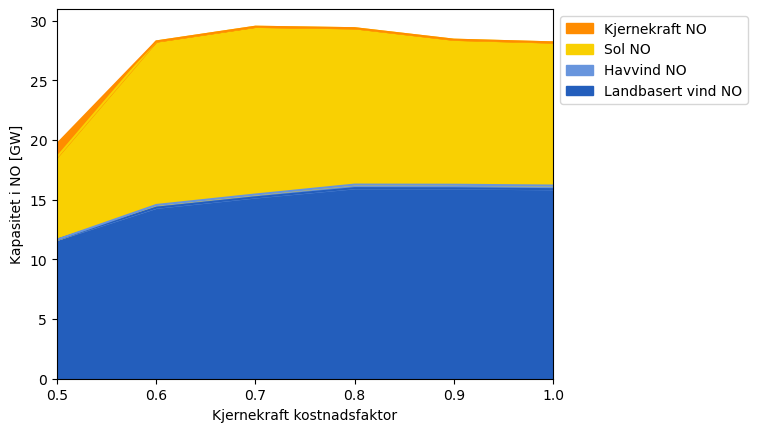

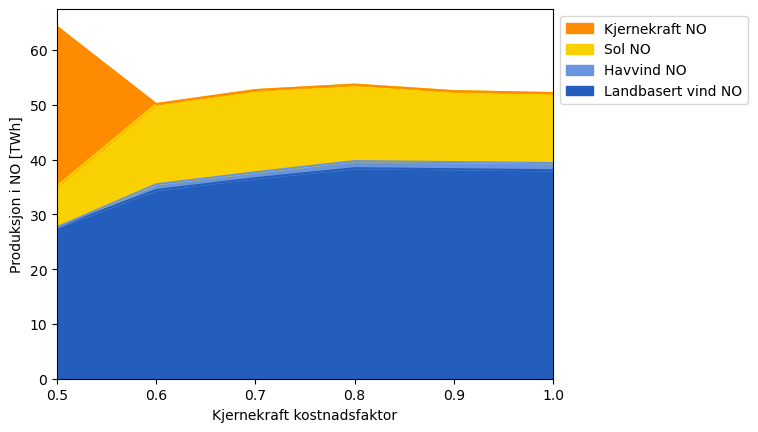

In [23]:
# Vis investering, kapasitet og produksjon i ulike teknologiar, både for Europa og Noreg.
for code in ["EU", "NO"]:
    for kind, pretty_kind, unit, factor in zip(
        ["inv", "cap", "prod"],
        ["Investering", "Kapasitet", "Produksjon"],
        ["Mrd. €", "GW", "TWh"],
        [1e-9, 1e-3, 1e-6],
    ):
        nets_by_nuclear_cost = (
            networks[
                [
                    f"onwind_{kind}_{code}",
                    f"offwind_{kind}_{code}",
                    f"solar_{kind}_{code}",
                    f"nuclear_{kind}_{code}",
                    f"nuclear_cost",
                ]
            ]
            .groupby("nuclear_cost")
            .mean()
            * factor
        )

        tech_names = {
            f"nuclear_{kind}_{code}": "nuclear",
            f"onwind_{kind}_{code}": "onwind",
            f"solar_{kind}_{code}": "solar",
            f"offwind_{kind}_{code}": "offwind",
        }
        ax = nets_by_nuclear_cost.plot.area(
            color={
                tech: config["plotting"]["tech_colors"][tech_names[tech]]
                for tech in tech_names
            }
        )
        ax.set_xlabel("Kjernekraft kostnadsfaktor")
        ax.set_ylabel(f"{pretty_kind} i {code} [{unit}]")
        # x axis bounds:
        ax.set_xlim(min(nets_by_nuclear_cost.index), max(nets_by_nuclear_cost.index))

        # Legend:
        pretty_names = {
            f"nuclear_{kind}_{code}": f"Kjernekraft {code}",
            f"onwind_{kind}_{code}": f"Landbasert vind {code}",
            f"solar_{kind}_{code}": f"Sol {code}",
            f"offwind_{kind}_{code}": f"Havvind {code}",
        }
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            reversed(handles),
            reversed([pretty_names[label] for label in labels]),
            loc="upper left",
            bbox_to_anchor=(1, 1),
        )

# Andre faktorar

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0, 0.5, 'Investering i kjernekraft i Norge [Mrd. €]')

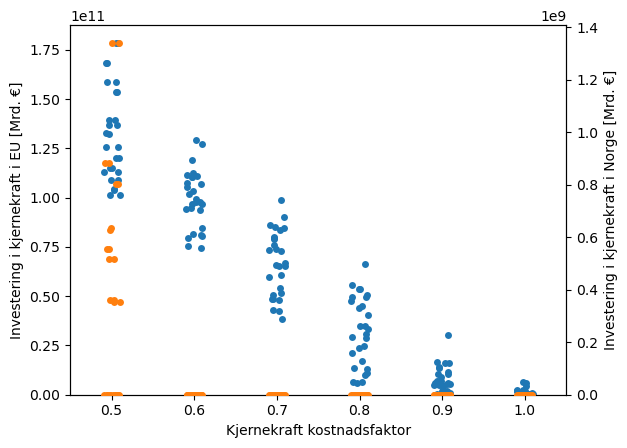

In [32]:
# Spreiing av investering i kjernekraft i ulike scenario.
fig, ax = plt.subplots()
sns.stripplot(x="nuclear_cost", y="nuclear_inv_EU", data=networks, jitter=True, ax=ax)
ax2 = ax.twinx()
sns.stripplot(x="nuclear_cost", y="nuclear_inv_NO", data=networks, jitter=True, color="tab:orange", ax=ax2)
ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0);
ax.set_xlabel("Kjernekraft kostnadsfaktor")
ax.set_ylabel("Investering i kjernekraft i EU [Mrd. €]")
ax2.set_ylabel("Investering i kjernekraft i Norge [Mrd. €]")

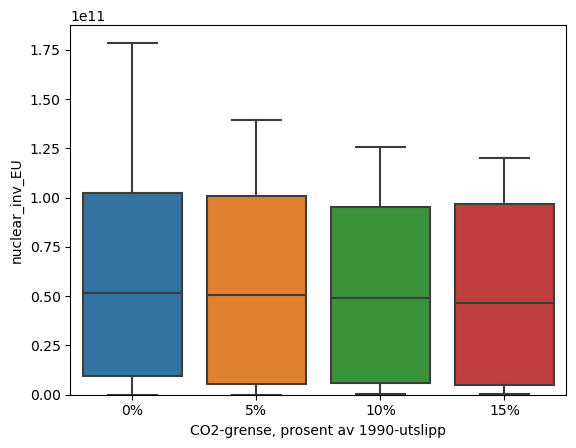

In [40]:
# Innflytelse av CO2-grense på investering i kjernekraft.
fig, ax = plt.subplots()
sns.boxplot(x="CO2", y="nuclear_inv_EU", data=networks, ax=ax)
ax.set_ylim(bottom=0)
ax.set_xticklabels([f"{int(x * 5)}%" for x in ax.get_xticks()])
ax.set_xlabel("CO2-grense, prosent av 1990-utslipp");